# Imports

In [1]:
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET

from PIL import Image, ImageDraw
from numpy import asarray
from bs4 import BeautifulSoup as bs

from object_detection.utils import config_util, visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [2]:
porcentagem_acerto = 0.1

# Funções de Controle de Imagem

In [3]:
def existeWBC(arquivo):
    content = []
    with open(arquivo, "r") as file:
        content = file.readlines()
        content = "".join(content)
        bs_content = bs(content, "lxml")
        lista_objetos = bs_content.find_all("object")

        for objeto in lista_objetos:
            nome = objeto.find("name")
            if "WBC" in nome:
                return True

    return False

In [4]:
def criarArquivo(mensagem, path):
    path = path.replace("imagens", "info")
    path = path.replace(".jpg", ".txt")
    mensagem = mensagem.replace("WBCs", "")
    arquivo = open(path, "w")
    arquivo.write("WBC\n")
    arquivo.write(mensagem)
    arquivo.close()

In [5]:
# Converte a imagem em array
def convertImageToArray(path):
    image = Image.open(path)
    array = asarray(image)
    return array


# Imprime as detecções na imagem
def plotDetections(imagem, boxes, classes, scores, categoria, nome=None):
    imagemDeteccao = imagem.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        imagemDeteccao, boxes, classes, scores, categoria, use_normalized_coordinates=True, min_score_thresh=porcentagem_acerto)

    if nome:
        pontuacao = np.squeeze(scores)
        contador = 0
        for i in range(100):
            if scores is None or pontuacao[i] > porcentagem_acerto:
                contador = contador + 1

        mensagem = str(contador) + " WBCs"

        plt.imsave(nome, imagemDeteccao)
        img = Image.open(nome)
        editor = ImageDraw.Draw(img)
        editor.text((10, 10), mensagem, fill=(255, 255, 0))

        criarArquivo(mensagem, nome)

        img.save(nome)
    else:
        plt.imshow(imagemDeteccao)


# Análise dos Dados

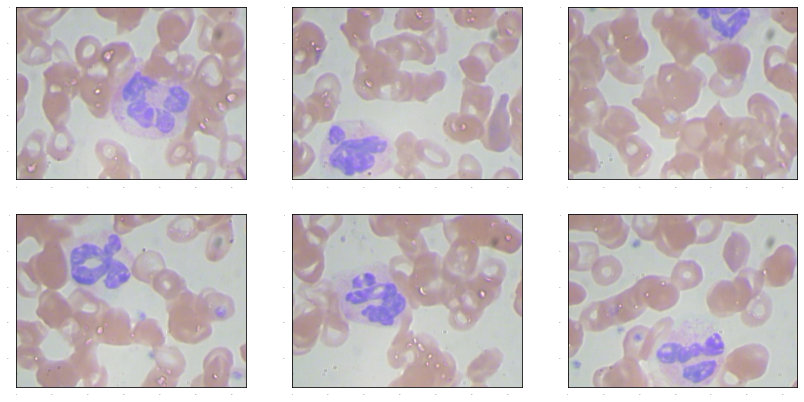

In [6]:
train_images_dir = './dataset-triple/train/imagens/'
train_images = []

# Coleta as imagens, converte em array e salva em array geral
for elemento in os.listdir(train_images_dir):
    imagem = os.path.join(train_images_dir, elemento)
    info = imagem.replace("imagens", "coordenadas")
    info = info.replace("jpg", "xml")
    if existeWBC(info):
        train_images.append(convertImageToArray(imagem))

# Parâmetros para a plotagem
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# Plotagem da visualização teste
for indice in range(0, 6):
    plt.subplot(2, 3, indice+1)
    plt.imshow(train_images[indice])
plt.show()

# Leitura das Coordenadas

In [7]:
# Função para realizar a conversão das coordenadas do XML para o formato utilizado no plot
def calcularPosicao(lista):
    xmin = lista[0]
    ymin = lista[1]
    xmax = lista[2]
    ymax = lista[3]

    larguraImagem = 640
    alturaImagem = 480

    xmin = xmin / larguraImagem
    ymin = ymin / alturaImagem
    xmax = xmax / larguraImagem
    ymax = ymax / alturaImagem

    return [ymin, xmin, ymax, xmax]

In [8]:
# Função para coletar as coordenadas do arquivo XML
def encontraWBC(arquivo):
    content = []
    with open(arquivo, "r") as file:
        content = file.readlines()
        content = "".join(content)
        bs_content = bs(content, "lxml")

        lista_objetos = bs_content.find_all("object")
        for objeto in lista_objetos:
            nome = objeto.find("name")
            xmin = objeto.find("xmin")
            ymin = objeto.find("ymin")
            xmax = objeto.find("xmax")
            ymax = objeto.find("ymax")

            if "WBC" in nome:
                nome = str(nome)
                xmin = str(xmin)
                ymin = str(ymin)
                xmax = str(xmax)
                ymax = str(ymax)

                # newNome = nome[nome.find(">")+1:nome.find("</name>")]
                newXmin = int(xmin[xmin.find(">")+1:xmin.find("</xmin>")])
                newYmin = int(ymin[ymin.find(">")+1:ymin.find("</ymin>")])
                newXmax = int(xmax[xmax.find(">")+1:xmax.find("</xmax>")])
                newYmax = int(ymax[ymax.find(">")+1:ymax.find("</ymax>")])

                return [newXmin, newYmin, newXmax, newYmax]
                
    return False

print(encontraWBC("dataset-triple/train/coordenadas/BloodImage_00125.xml"))

[104, 149, 275, 302]


In [9]:
# Importação das coordenadas para um array
coordenadas_dir = 'dataset-triple/train/coordenadas/'
coordenadas_info = []

for arquivo in os.listdir(coordenadas_dir):
    if existeWBC(coordenadas_dir + arquivo):
        coordenadas_info.append(np.array(
            [calcularPosicao(encontraWBC(coordenadas_dir + arquivo))], dtype=np.float32))

for i in range(0, 6):
    print(coordenadas_info[i])

[[0.36875    0.40625    0.78333336 0.7671875 ]]
[[0.65625  0.10625  1.       0.446875]]
[[0.00208333 0.4421875  0.22083333 0.8859375 ]]
[[0.08333334 0.1984375  0.47083333 0.5375    ]]
[[0.27916667 0.1703125  0.66875    0.50625   ]]
[[0.6       0.359375  1.        0.6890625]]


# Preparando dados para treinamento

In [10]:
# Definição da classe
wbc_id = 1
num_classes = 1
categorias = {wbc_id: {'id': wbc_id, 'name': 'wbc'}}

train_images_tensors = []
coordenadas_info_tensors = []
offset = 1
classes_tensors = []

# Função Zip = Tupla entre dois arryas (Imagens + Coordenadas)
for (train_image, coordenada) in zip(train_images, coordenadas_info):
    train_images_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image, dtype=tf.float32), axis=0))
    coordenadas_info_tensors.append(tf.convert_to_tensor(coordenada, dtype=tf.float32))
    indices = tf.convert_to_tensor(np.ones(shape=[coordenada.shape[0]], dtype=np.int32) - offset)
    classes_tensors.append(tf.one_hot(indices, num_classes))

print('Dados preparados')

Dados preparados


# Visualizando imagens com coordenadas

In [11]:
print(len(train_images))
print(len(coordenadas_info))

285
285


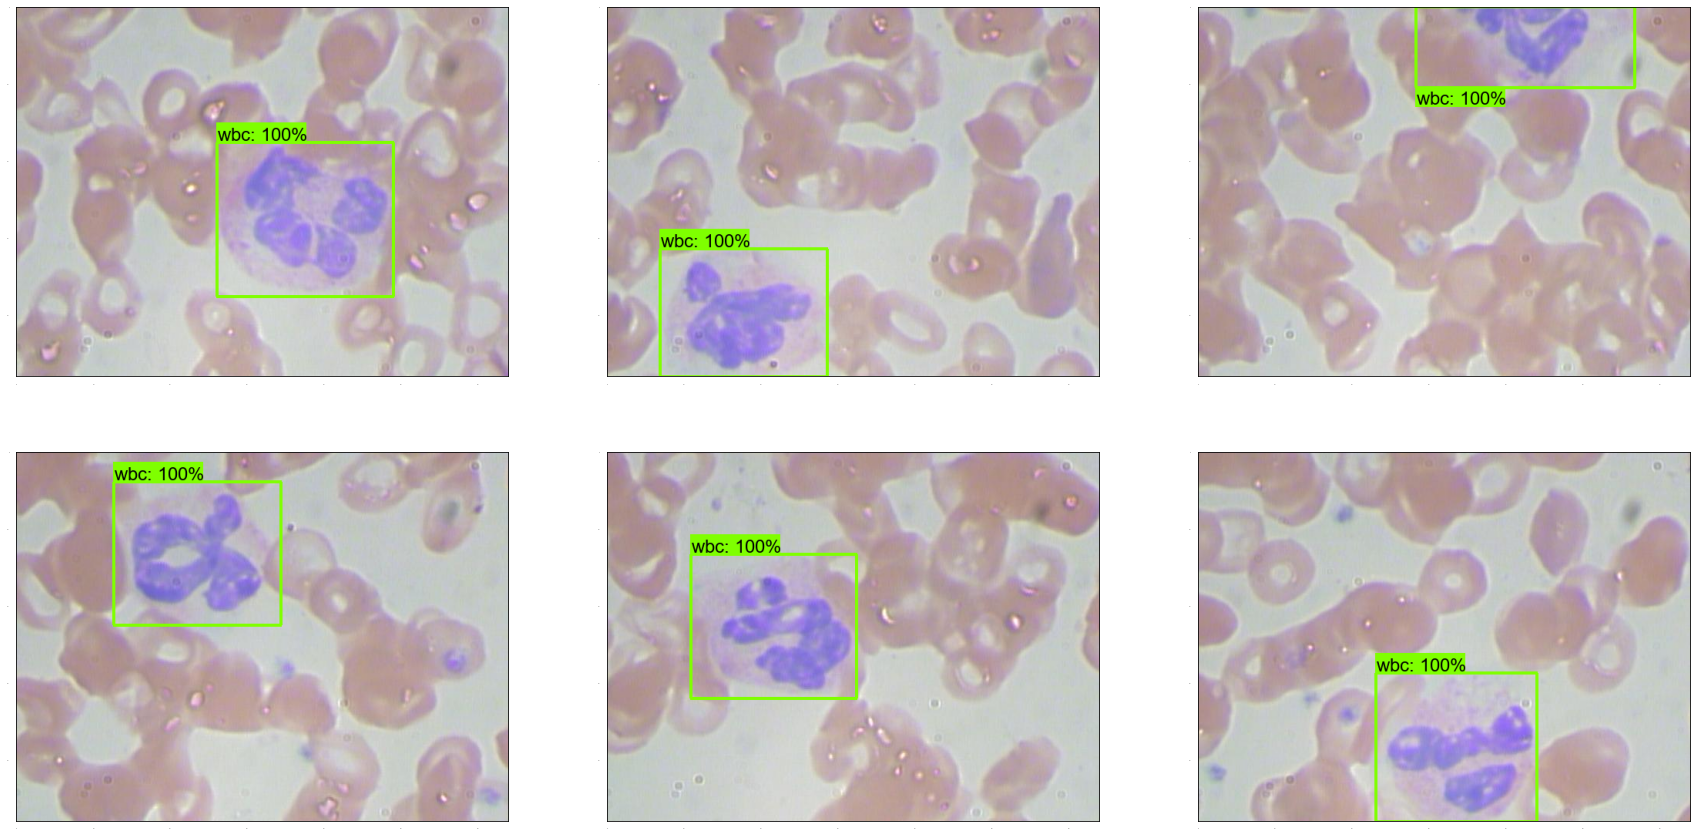

In [12]:
fake_score = np.array([1.0], dtype=np.float32)

plt.figure(figsize=(30, 15))
for indice in range(0, 6):
    plt.subplot(2, 3, indice+1)
    plotDetections(
        train_images[indice],
        coordenadas_info[indice],
        np.ones(shape=[coordenadas_info[indice].shape[0]], dtype=np.int32),
        fake_score, categorias)
plt.show()

# Criar modelo e trabalhar com checkpoints

In [13]:
tf.keras.backend.clear_session()
print('Construindo modelo e restaurando pesos para fine-tuning...', flush=True)

# Parâmetros do modelo
num_classes = 1
pipeline_config = '../models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config'
checkpoint_path = './checkpoint-1'

# Salvar checkpoint e configurações
output_directory = '../prototype/saves/wbc/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Importação e definição
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True

# Construção do Modelo
model = model_builder.build(model_config=model_config, is_training=True)

# Salvar pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

fakebox_predictor = tf.compat.v2.train.Checkpoint(_base_tower_layers_for_heads=model._box_predictor._base_tower_layers_for_heads,
                                                  _box_prediction_head=model._box_predictor._box_prediction_head)
fake_model = tf.compat.v2.train.Checkpoint(
    _feature_extractor=model._feature_extractor, _box_predictor=fakebox_predictor)

checkpoint = tf.compat.v2.train.Checkpoint(model=model) # O SEGREDO TA AQUI
checkpoint.restore(checkpoint_path).expect_partial()

image, shapes = model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = model.predict(image, shapes)
_ = model.postprocess(prediction_dict, shapes)
print('Pesos restaurados!')

Construindo modelo e restaurando pesos para fine-tuning...
INFO:tensorflow:Writing pipeline config file to ../prototype/saves/wbc/pipeline.config
Pesos restaurados!


# Loop de treinamento personalizado

# Carregar imagens para teste e aplicar no modelo

In [14]:
modelo = pipeline_config
modelo = modelo.replace("../models/", "")
modelo = modelo.replace("/pipeline.config", "")

resultados = "./resultados"

resultados_path = "./results-triple/" + str(resultados)
imagem_path = resultados_path + "/wbc/imagens/"
info_path = resultados_path + "/wbc/info/" 

print(resultados_path)
if not os.path.isdir(imagem_path):
    os.makedirs(imagem_path)
if not os.path.isdir(info_path):
    os.makedirs(info_path)

./results-triple/./resultados


In [15]:
test_image_dir = 'dataset-triple/test/imagens/'
test_images = []
test_images_nomes = []

for elemento in os.listdir(test_image_dir):
    imagem = os.path.join(test_image_dir, elemento)
    test_images_nomes.append(elemento)
    test_images.append(np.expand_dims(convertImageToArray(imagem), axis=0))

@tf.function
def detectar(input_tensor):
    prepross_image, formas = model.preprocess(input_tensor)
    predicao_dict = model.predict(prepross_image, formas)
    return model.postprocess(predicao_dict, formas)

offset = 1
for i in range(len(test_images)):
    test_tensor = tf.convert_to_tensor(test_images[i], dtype=tf.float32)
    deteccoes = detectar(test_tensor)

    plotDetections(
        test_images[i][0],
        deteccoes['detection_boxes'][0].numpy(),
        deteccoes['detection_classes'][0].numpy().astype(np.uint32) + offset,
        deteccoes['detection_scores'][0].numpy(),
        categorias, nome=imagem_path + test_images_nomes[i])

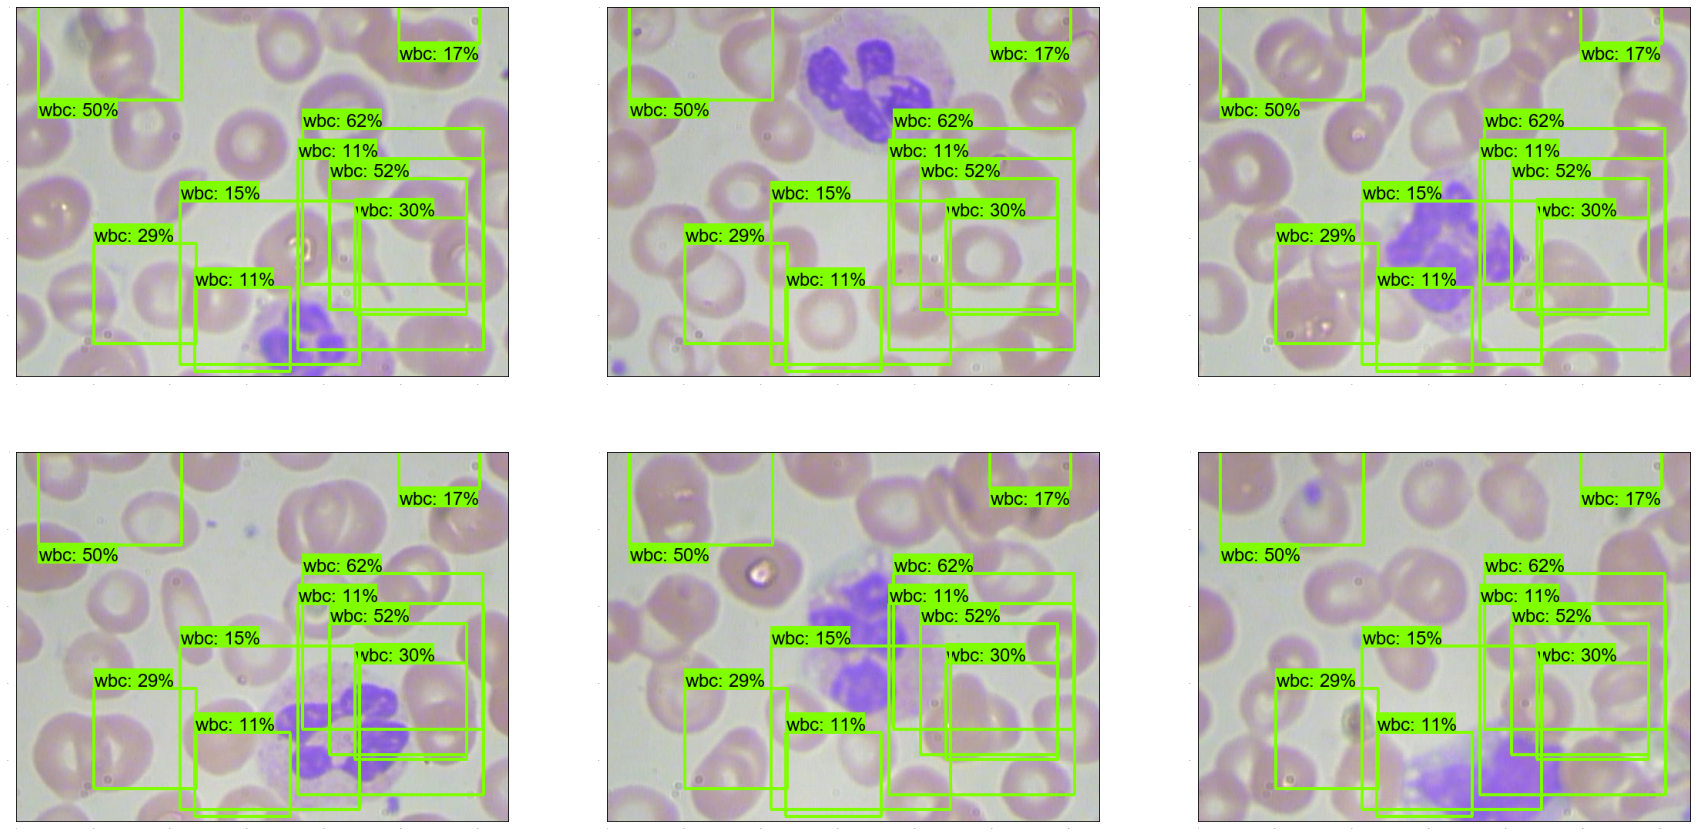

In [16]:
plt.figure(figsize=(30, 15))
for indice in range(0, 6):
        plt.subplot(2, 3, indice+1)
        plotDetections(
                test_images[indice][0],
                deteccoes['detection_boxes'][0].numpy(),
                deteccoes['detection_classes'][0].numpy().astype(np.uint32) + offset,
                deteccoes['detection_scores'][0].numpy(),
                categorias)
plt.show()

In [17]:
# ckpt_manager.save()
# print('Checkpoint saved!')

In [18]:
print(model.weights)

[<tf.Variable 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0' shape=(3, 3, 256, 24) dtype=float32, numpy=
array([[[[-5.62798372e-03,  4.28375136e-03, -4.22584964e-03, ...,
           6.44845888e-03,  5.51871210e-03,  6.51482493e-04],
         [-5.25810756e-03,  5.10955928e-03,  1.42871384e-02, ...,
           2.11665151e-03,  4.85868310e-04, -2.28620629e-04],
         [-5.37808193e-03,  3.18198884e-03,  1.07185915e-03, ...,
          -2.76082568e-03, -1.55687965e-02, -2.89535010e-03],
         ...,
         [ 5.45051589e-04,  2.61572283e-03, -2.73493002e-03, ...,
          -3.33722169e-03, -5.67273470e-03, -4.20957105e-03],
         [-7.21268472e-04,  1.59682322e-03,  1.65849272e-03, ...,
           6.58807170e-04,  6.43069448e-04, -3.03520123e-03],
         [ 1.92057423e-03,  2.23812927e-03,  7.98879133e-04, ...,
           4.92816418e-03, -1.17714604e-04, -4.44003288e-03]],

        [[ 1.05840284e-02,  5.09529375e-03, -7.66233960e-03, ..

In [19]:
type(model)

object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch

In [20]:
import servidor
servidor.start(model, "./dataset-triple/test/imagens/BloodImage_00333.jpg")